# Assignment 2

Welcome to the second assignment! We're excited to see what you'll create using the techniques you've learned in this course.

First of all, please type your name and UID in the following format:

Firstname Lastname, #UID

For example: Sicheng Mo, #401234567

In [ ]:
#@title Your Info { display-mode: "form" }

Name = 'Victoria Lam' #@param {type:"string"}
UID = '305608770' #@param {type:"string"}

### Goals
The goals of this assignment are to:

1. Implement a PyTorch data loader to load and preprocess the MiniPlaces dataset.
2. Build and train a fully-connected neural network from scratch and using built-in PyTorch modules.
3. Build and train a convolutional neural network from scratch and using built-in PyTorch modules.
4. Come up with your own model and compete on a test leaderboard for extra credit.

By the end of this assignment, you will have gained experience with:

- Working with PyTorch and the MiniPlaces dataset for image classification.
- Implementing and training different types of neural networks using PyTorch.
- Debugging and troubleshooting issues that may arise during the development process.

Please note that it may take some time to run the entire notebook and prepare the submission version. Make sure to allocate enough time for this task and start early. If you have any questions or run into any issues, please feel free to raise them in the Piazza forum or search the internet for debugging purposes. However, please do not directly copy code from other sources.

This assignment is due on ***Feb 12th***.

**Do not use any Code AI to finish the assignment.**


Good luck and happy coding! Remember, the most important thing is to have fun and learn something new.





## Q1: Data Loader (20 pts)

In this part, you will implement a PyTorch data loader to load and preprocess the MiniPlaces dataset.

To begin, you will need to download the MiniPlaces dataset using the provided link. 

-----

### Q1.0: Data prepartion (0 pts)

Recall the introduction about the storage system of CoLab we went through in the assignment 1. For efficient development of our models, we will still use the temporary storage space to hold our data. This means that every time you open up this notebook, we will need to re-download and process the dataset. Don't worry though - this shouldn't take long, usually just a minute or less. Okay, let's get started!

As in the assignment 1, we download the Miniplaces Dataset from its google drive file ID.

Downloading this dataset only takes less than 15 seconds.

In [1]:
# Downloading this file takes about a few seconds.
# Download the tar.gz file from google drive using its file ID.
!pip3 install --upgrade gdown --quiet
!gdown 16GYHdSWS3iMYwMPv5FpeDZN2rH7PR0F2 # this is the file ID of miniplaces dataset
# back-up commands (try the following it previous file id is overload)
# !gdown 1CyIQOJienhNITwGcQ9h-nv8z6GOjV2HX
# !wget https://web.cs.ucla.edu/~smo3/data.tar.gz


Downloading...
From: https://drive.google.com/uc?id=16GYHdSWS3iMYwMPv5FpeDZN2rH7PR0F2
To: /content/data.tar.gz
100% 460M/460M [00:12<00:00, 36.3MB/s]


In [2]:
import os
import tarfile
from tqdm import tqdm
import urllib.request

def setup(file_link_dict={},
          folder_name='Assignment2'):
  # Let's make our assignment directory
  CS188_path = './'
  os.makedirs(os.path.join(CS188_path, 'Assignment2', 'data'), exist_ok=True)
  # Now, let's specify the assignment path we will be working with as the root.
  root_dir = os.path.join(CS188_path, 'Assignment2')
  # Open the tar.gz file
  tar = tarfile.open("data.tar.gz", "r:gz")
  # Extract the file "./Assignment2/data" folder
  total_size = sum(f.size for f in tar.getmembers())
  with tqdm(total=total_size, unit="B", unit_scale=True, desc="Extracting tar.gz file") as pbar:
      for member in tar.getmembers():
          tar.extract(member, os.path.join(root_dir, 'data'))
          pbar.update(member.size)
  # Close the tar.gz file
  tar.close()
  # Next, we download the train/val/test txt files:
  for file_name, file_link in file_link_dict.items():
      print(f'Downloding {file_name}.txt from {file_link}')
      urllib.request.urlretrieve(file_link, f'{root_dir}/data/{file_name}.txt')
  return root_dir

In [3]:
val_url = 'https://raw.githubusercontent.com/CSAILVision/miniplaces/master/data/val.txt'
train_url = 'https://raw.githubusercontent.com/CSAILVision/miniplaces/master/data/train.txt'
root_dir = setup(
    file_link_dict={'train':train_url, 'val':val_url},
    folder_name='Assignment2')

Extracting tar.gz file: 100%|██████████| 566M/566M [00:22<00:00, 25.4MB/s]


Downloding train.txt from https://raw.githubusercontent.com/CSAILVision/miniplaces/master/data/train.txt
Downloding val.txt from https://raw.githubusercontent.com/CSAILVision/miniplaces/master/data/val.txt


If you are curious, however, here is an example output if you choose to extract the files to Google Drive:

```
Extracting tar.gz file: 100%|██████████| 566M/566M [21:49<00:00, 432kB/s] 
```

In contrast, extracting files to temporary workspace only takes ~20-40 seconds.

### Q1.1 Data Transform (10 pts)

In this sub-question, you will be loading a sample image from the MiniPlaces dataset and applying a data transformation to it using the `torchvision.transforms.Compose` function.

First, let's load a sample image from the `{root_dir}/data/images/train/a/abbey/00000001.jpg` file and print some properties about it:


Data type of my image: <class 'PIL.JpegImagePlugin.JpegImageFile'>
Shape of image: (128, 128, 3)
Channel mode: RGB
Value range of image: ((0, 255), (0, 255), (0, 255))


(-0.5, 127.5, 127.5, -0.5)

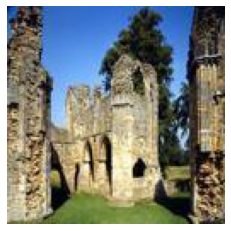

In [4]:
# Import necessary libraries
from PIL import Image  # we call this library "pillow"

import numpy as np
import matplotlib.pyplot as plt

# Load sample image
image = Image.open(f'{root_dir}/data/images/train/a/abbey/00000001.jpg')
print(f'Data type of my image: {type(image)}')
print(f"Shape of image: {np.array(image).shape}")
print(f'Channel mode:', image.mode)
print(f"Value range of image: {image.getextrema()}")

# Display image using matplotlib
plt.imshow(image)
plt.axis('off')


You should be aware of the following data properties:
* The loaded image is in the format of "channel-last", with the shape of (height, width, channels), instead of (channels, height, width) which is the default in **opencv**.
* The channel mode is RGB, meaning the channels are ordered as red, green, and blue, as opposed to BGR which is commonly used in **opencv**. 
* The value range of the data is between 0 and 255, so the data type is most likely uint8.

It is important to keep in mind these subtle differences when loading images using **opencv** or **PIL**. Be mindful of these variations when working with image data. **After the first assignment, most of you should know the difference between RGB and BGR images when visulizing.**


In addition to the sample image, you can also experiment with loading other images from the dataset for further exploration.

---

All images in the MiniPlaces dataset have a shape of (128, 128), and have a `uint8` (0~255) data type. 

Next, you should define a data transform function using torchvision.transforms.Compose that resizes the image to 64x64, converts it to a tensor, and normalizes it using ImageNet statistics, i.e., `mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]`

In [5]:
from torchvision import transforms

# Define data transformation
data_transform = transforms.Compose([
    ################# Your Implementations #####################################
    # TODO: Resize image to 64x64
    transforms.Resize((64, 64)),
    #pass

    ################# End of your Implementations ##############################
    transforms.ToTensor(),


    ################# Your Implementations #####################################
    # TODO: Normalize image using ImageNet statistics
    # Normalize(mean, std)
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
    #pass
    
    ################# End of your Implementations ##############################
])


Let's see how `data_transform` works:

In [6]:
transformed_img = data_transform(image)
print('shape:', transformed_img.shape)
print('values:', transformed_img)

shape: torch.Size([3, 64, 64])
values: tensor([[[-1.8782, -1.8097, -1.4672,  ..., -1.8953, -1.9638, -1.9980],
         [-1.7069, -1.6384, -1.4158,  ..., -1.9124, -1.9809, -1.9980],
         [-1.4843, -1.4500, -1.4158,  ..., -1.6898, -1.9124, -1.9638],
         ...,
         [ 1.2557,  1.1015,  1.2043,  ...,  0.1254,  0.5022,  0.1083],
         [ 1.1015,  0.8276,  0.9817,  ..., -0.8164, -0.5253, -0.5938],
         [ 0.3138, -0.0801, -0.0287,  ..., -1.1589, -1.1247, -0.8678]],

        [[-1.3529, -0.8452, -0.6001,  ..., -1.8431, -1.8782, -1.8782],
         [-0.9853, -0.5826, -0.5476,  ..., -1.8431, -1.8957, -1.8957],
         [-0.6001, -0.4251, -0.6527,  ..., -1.6331, -1.8256, -1.8431],
         ...,
         [ 1.2731,  1.1331,  1.2731,  ...,  0.0476,  0.4328, -0.0049],
         [ 1.1331,  0.8880,  1.0980,  ..., -0.8277, -0.5301, -0.6001],
         [ 0.3627, -0.0224,  0.1001,  ..., -1.1429, -1.0903, -0.7927]],

        [[ 0.1128,  0.8448,  0.8274,  ..., -1.4733, -1.4559, -1.4384],
      

You should get results similar to the following if you're using the same image (`f'{root_dir}/data/images/train/a/abbey/00000001.jpg`):

```
shape: torch.Size([3, 64, 64])
values: tensor([[[-1.8782, -1.8097, -1.4672,  ..., -1.8953, -1.9638, -1.9980],
         [-1.7069, -1.6384, -1.4158,  ..., -1.9124, -1.9809, -1.9980],
         [-1.4843, -1.4500, -1.4158,  ..., -1.6898, -1.9124, -1.9638],      
         ...,
         [ 1.1237,  0.9668,  1.0539,  ..., -0.2532,  0.2522, -0.0267],
         [ 0.8274,  0.5485,  0.7054,  ..., -0.9853, -0.6890, -0.6890],
         [-0.1138, -0.5147, -0.4624,  ..., -1.1770, -1.2293, -0.9504]]])
```

Let's take a look at the `transforms.ToTensor()` only.

In [7]:
print('original image:',
      f'  type: {type(image)}',
      f'  shape: {np.array(image).shape}',
      f'  values: max={np.max(image)}, min={np.min(image)}',
      sep='\n')

_t_img = transforms.ToTensor()(image)
print('after ToTensor transformation:',
      f'  type: {type(_t_img)}',
      f'  shape: {_t_img.shape}',
      f'  values: max={_t_img.max()}, min={_t_img.min()}',
      sep='\n')


original image:
  type: <class 'PIL.JpegImagePlugin.JpegImageFile'>
  shape: (128, 128, 3)
  values: max=255, min=0
after ToTensor transformation:
  type: <class 'torch.Tensor'>
  shape: torch.Size([3, 128, 128])
  values: max=1.0, min=0.0


In 1-2 sentences, explain in your own words what the `transforms.ToTensor()` function does.

(Double click to edit)

Your answer: transforms.ToTensor() converts the PIL image to have a shape of (channels, Height, Width) in the values range of [0.0, 1.0].

---

After defining the data transform function, you can use it to transform the sample image and visualize the result. Here is an example.


Note that the `imshow` function expects the image to be in the format `(height, width, channels)`, but the transformed image has the shape `(channels, height, width)`. We can use the permute method to rearrange the dimensions of the transformed image.

(-0.5, 63.5, 63.5, -0.5)

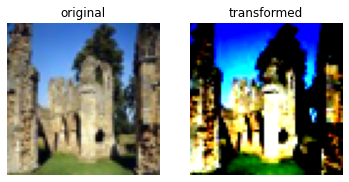

In [8]:
plt.subplot(1,2,1)
plt.imshow(image.resize((64,64)))
plt.title('original')
plt.axis('off')
plt.subplot(1,2,2)
plt.imshow(transformed_img.permute(1, 2, 0))
plt.title('transformed')
plt.axis('off')

You will find that the transformed image is significantly distorted in terms of color.

This is caused by the normalization step. Therefore, we need to undo this step to recover the original image.

To do this, let's write a `tensor_to_image` function that inverts the data transformation process. This function should take a tensor image as input and return a displayable image.

In [9]:
import torch
from torchvision import transforms

def tensor_to_image(image):
    """
    Convert a tensor image back to a displayable image.
    
    Args:
        image (torch.Tensor): Tensor image to convert.
        
    Returns:
        PIL.Image: Displayable image.
    """
    tensor_image = image.clone().detach()
    # TODO: transform the tensor_image into a numpy_image that is displayable by plt.
    ################# Your Implementations #####################################
    # Hints: Transpose tensor image to (64, 64, 3)
    #         Undo normalization
    #         Convert tensor image to numpy array
    #pass
    #undo normalization
    inv_norm = transforms.Compose([ transforms.Normalize(mean = [0., 0., 0.], std = [1/0.229, 1/0.224, 1/0.225]),
              transforms.Normalize(mean = [-0.485, -0.456, -0.406], std = [1., 1., 1.]), ])
    numpy_image = inv_norm(tensor_image)
    #transpose/swap axes
    numpy_image = torch.swapaxes(numpy_image, 0, 1)
    numpy_image = torch.swapaxes(numpy_image, 1, 2)
    #convert to numpy array
    numpy_image = numpy_image.detach().numpy()

    image = numpy_image
    
    ################# End of your Implementations ##############################
    return image


(-0.5, 63.5, 63.5, -0.5)

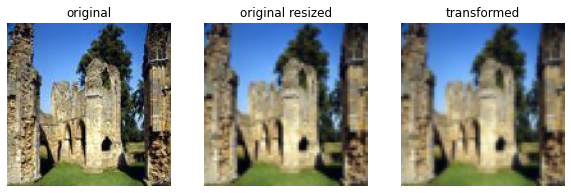

In [10]:
# Let's see the results.
fig = plt.figure(figsize=(10,3))
plt.subplot(1,3,1)
plt.title('original')
plt.imshow(image)
plt.axis('off')
plt.subplot(1,3,2)
plt.title('original resized')
plt.imshow(image.resize((64,64)))
plt.axis('off')
plt.subplot(1,3,3)
plt.imshow(tensor_to_image(transformed_img))
plt.title('transformed')
plt.axis('off')

### Q1.2 MiniPlaces Dataloader (10 pts)

You will implement a pytorch data loader for the MiniPlaces dataset, following the tutorial [here](https://colab.research.google.com/github/pytorch/tutorials/blob/gh-pages/_downloads/57a471142057f27da635118e88a99bf6/data_tutorial.ipynb
) or referring to our discussion 2.

Complete the following cell and debug it if necessary.

In [93]:
import os
import torch
from torch.utils.data import Dataset
from PIL import Image
import numpy as np

class MiniPlaces(Dataset):
    def __init__(self, root_dir, split, transform=None, label_dict=None):
        """
        Initialize the MiniPlaces dataset with the root directory for the images, 
        the split (train/val/test), an optional data transformation, 
        and an optional label dictionary.
        
        Args:
            root_dir (str): Root directory for the MiniPlaces images.
            split (str): Split to use ('train', 'val', or 'test').
            transform (callable, optional): Optional data transformation to apply to the images.
            label_dict (dict, optional): Optional dictionary mapping integer labels to class names.
        """
        assert split in ['train', 'val', 'test']
        self.root_dir = root_dir
        self.split = split
        self.transform = transform
        self.filenames = []
        self.labels = []

        # Take a second to think why we need this line.
        # Hints: training set / validation set / test set.
        self.label_dict = label_dict if label_dict is not None else {}

        # You should
        #   1. Load the train/val/test text file based on the `split` argument and
        #     store the image filenames and labels.
        #   2. Extract the class names from the image filenames and store them in 
        #     self.label_dict.
        #   3. Construct a label dict that maps integer labels to class names, if 
        #     the current split is "train" 
        ################# Your Implementations #####################################
        #pass
        # load/open file and store the filenames and labels
        if split == 'test':
          for entry in os.listdir('./Assignment2/data/images/test'):
            self.filenames.append(entry[:-4])
          self.filenames.sort()
        else:
          with open(f"{root_dir}/{split}.txt") as open_file:
            for line in open_file.readlines():
              filename, label = line.strip().split()
              self.filenames.append(filename)
              self.labels.append(int(label))
              if split == 'train':
                self.label_dict[int(label)] = filename.split("/")[2]

        ################# End of your Implementations ##############################

    def __len__(self):
        """
        Return the number of images in the dataset.
        
        Returns:
            int: Number of images in the dataset.
        """
        dataset_len = 0
        ################# Your Implementations #####################################
        # Return the number of images in the dataset
        #pass
        dataset_len = len(self.filenames)

        ################# End of your Implementations ##############################
        return dataset_len
    
    
    def __getitem__(self, idx):
        """
        Return a single image and its corresponding label when given an index.
        
        Args:
            idx (int): Index of the image to retrieve.
            
        Returns:
            tuple: Tuple containing the image and its label.
        """
        ################# Your Implementations #####################################
        # Load and preprocess image using self.root_dir, 
        # self.filenames[idx], and self.transform (if specified)
        #pass 
        if self.split == 'test':
          return self.transform(Image.open(f'./Assignment2/data/images/test/{self.filenames[idx]}.jpg')), self.filenames[idx]
        
        filename = self.filenames[idx]
        label = self.labels[idx]

        image = Image.open(f'{root_dir}/data/images/{filename}')
        image = self.transform(image)

        ################# End of your Implementations ##############################
        return image, label

In [12]:
data_root = os.path.join(root_dir, 'data')
# Create MiniPlaces dataset object
miniplaces_train = MiniPlaces(data_root, split='train', transform=data_transform)

# Check our implementation
print('len of trainining dataset:', len(miniplaces_train))
print('label_dict:', miniplaces_train.label_dict)
random_idxs = np.random.choice(len(miniplaces_train), 3)
print('Example filenames:', [miniplaces_train.filenames[i] for i in random_idxs])
print('Example class IDs:', [miniplaces_train.labels[i] for i in random_idxs])
print('Example class names:', 
      [miniplaces_train.label_dict[miniplaces_train.labels[i]] for i in random_idxs])
print()

miniplaces_val = MiniPlaces(data_root, split='val', transform=data_transform)
print('val label_dict:', miniplaces_val.label_dict)

len of trainining dataset: 100000
label_dict: {0: 'abbey', 1: 'airport_terminal', 2: 'amphitheater', 3: 'amusement_park', 4: 'aquarium', 5: 'aqueduct', 6: 'art_gallery', 7: 'assembly_line', 8: 'auditorium', 9: 'badlands', 10: 'bakery', 11: 'ballroom', 12: 'bamboo_forest', 13: 'banquet_hall', 14: 'bar', 15: 'baseball_field', 16: 'bathroom', 17: 'beauty_salon', 18: 'bedroom', 19: 'boat_deck', 20: 'bookstore', 21: 'botanical_garden', 22: 'bowling_alley', 23: 'boxing_ring', 24: 'bridge', 25: 'bus_interior', 26: 'butchers_shop', 27: 'campsite', 28: 'candy_store', 29: 'canyon', 30: 'cemetery', 31: 'chalet', 32: 'church', 33: 'classroom', 34: 'clothing_store', 35: 'coast', 36: 'cockpit', 37: 'coffee_shop', 38: 'conference_room', 39: 'construction_site', 40: 'corn_field', 41: 'corridor', 42: 'courtyard', 43: 'dam', 44: 'desert', 45: 'dining_room', 46: 'driveway', 47: 'fire_station', 48: 'food_court', 49: 'fountain', 50: 'gas_station', 51: 'golf_course', 52: 'harbor', 53: 'highway', 54: 'hospit

If you have successfully implemented the dataset, the above code should give you results like this:


```
len of trainining dataset: 100000
label_dict: {0: 'abbey', 1: 'airport_terminal', 2: 'amphitheater', 3: 'amusement_park', 4: 'aquarium', 5: 'aqueduct', 6: 'art_gallery', 7: 'assembly_line', 8: 'auditorium', 9: 'badlands', 10: 'bakery', 11: 'ballroom', 12: 'bamboo_forest', 13: 'banquet_hall', 14: 'bar', 15: 'baseball_field', 16: 'bathroom', 17: 'beauty_salon', 18: 'bedroom', 19: 'boat_deck', 20: 'bookstore', 21: 'botanical_garden', 22: 'bowling_alley', 23: 'boxing_ring', 24: 'bridge', 25: 'bus_interior', 26: 'butchers_shop', 27: 'campsite', 28: 'candy_store', 29: 'canyon', 30: 'cemetery', 31: 'chalet', 32: 'church', 33: 'classroom', 34: 'clothing_store', 35: 'coast', 36: 'cockpit', 37: 'coffee_shop', 38: 'conference_room', 39: 'construction_site', 40: 'corn_field', 41: 'corridor', 42: 'courtyard', 43: 'dam', 44: 'desert', 45: 'dining_room', 46: 'driveway', 47: 'fire_station', 48: 'food_court', 49: 'fountain', 50: 'gas_station', 51: 'golf_course', 52: 'harbor', 53: 'highway', 54: 'hospital_room', 55: 'hot_spring', 56: 'ice_skating_rink', 57: 'iceberg', 58: 'kindergarden_classroom', 59: 'kitchen', 60: 'laundromat', 61: 'lighthouse', 62: 'living_room', 63: 'lobby', 64: 'locker_room', 65: 'market', 66: 'martial_arts_gym', 67: 'monastery', 68: 'mountain', 69: 'museum', 70: 'office', 71: 'palace', 72: 'parking_lot', 73: 'phone_booth', 74: 'playground', 75: 'racecourse', 76: 'railroad_track', 77: 'rainforest', 78: 'restaurant', 79: 'river', 80: 'rock_arch', 81: 'runway', 82: 'shed', 83: 'shower', 84: 'ski_slope', 85: 'skyscraper', 86: 'slum', 87: 'stadium', 88: 'stage', 89: 'staircase', 90: 'subway_station', 91: 'supermarket', 92: 'swamp', 93: 'swimming_pool', 94: 'temple', 95: 'track', 96: 'trench', 97: 'valley', 98: 'volcano', 99: 'yard'}
Example filenames: ['train/b/boat_deck/00000794.jpg', 'train/b/bookstore/00000781.jpg', 'train/s/swamp/00000783.jpg']
Example class IDs: [19, 20, 92]
Example class names: ['boat_deck', 'bookstore', 'swamp']

val label_dict: {}
```

----
Since validation and test annotation files do not have class information, we should pass the `label_dict` obtained from the training set to them.


In [13]:
miniplaces_val = MiniPlaces(
    data_root, split='val', 
    transform=data_transform, 
    label_dict=miniplaces_train.label_dict)

print('val label_dict:', miniplaces_val.label_dict)


val label_dict: {0: 'abbey', 1: 'airport_terminal', 2: 'amphitheater', 3: 'amusement_park', 4: 'aquarium', 5: 'aqueduct', 6: 'art_gallery', 7: 'assembly_line', 8: 'auditorium', 9: 'badlands', 10: 'bakery', 11: 'ballroom', 12: 'bamboo_forest', 13: 'banquet_hall', 14: 'bar', 15: 'baseball_field', 16: 'bathroom', 17: 'beauty_salon', 18: 'bedroom', 19: 'boat_deck', 20: 'bookstore', 21: 'botanical_garden', 22: 'bowling_alley', 23: 'boxing_ring', 24: 'bridge', 25: 'bus_interior', 26: 'butchers_shop', 27: 'campsite', 28: 'candy_store', 29: 'canyon', 30: 'cemetery', 31: 'chalet', 32: 'church', 33: 'classroom', 34: 'clothing_store', 35: 'coast', 36: 'cockpit', 37: 'coffee_shop', 38: 'conference_room', 39: 'construction_site', 40: 'corn_field', 41: 'corridor', 42: 'courtyard', 43: 'dam', 44: 'desert', 45: 'dining_room', 46: 'driveway', 47: 'fire_station', 48: 'food_court', 49: 'fountain', 50: 'gas_station', 51: 'golf_course', 52: 'harbor', 53: 'highway', 54: 'hospital_room', 55: 'hot_spring', 56

Now you should see the same `label_dict` as the tranining set.

---

Next, let's visualize the image in each category.

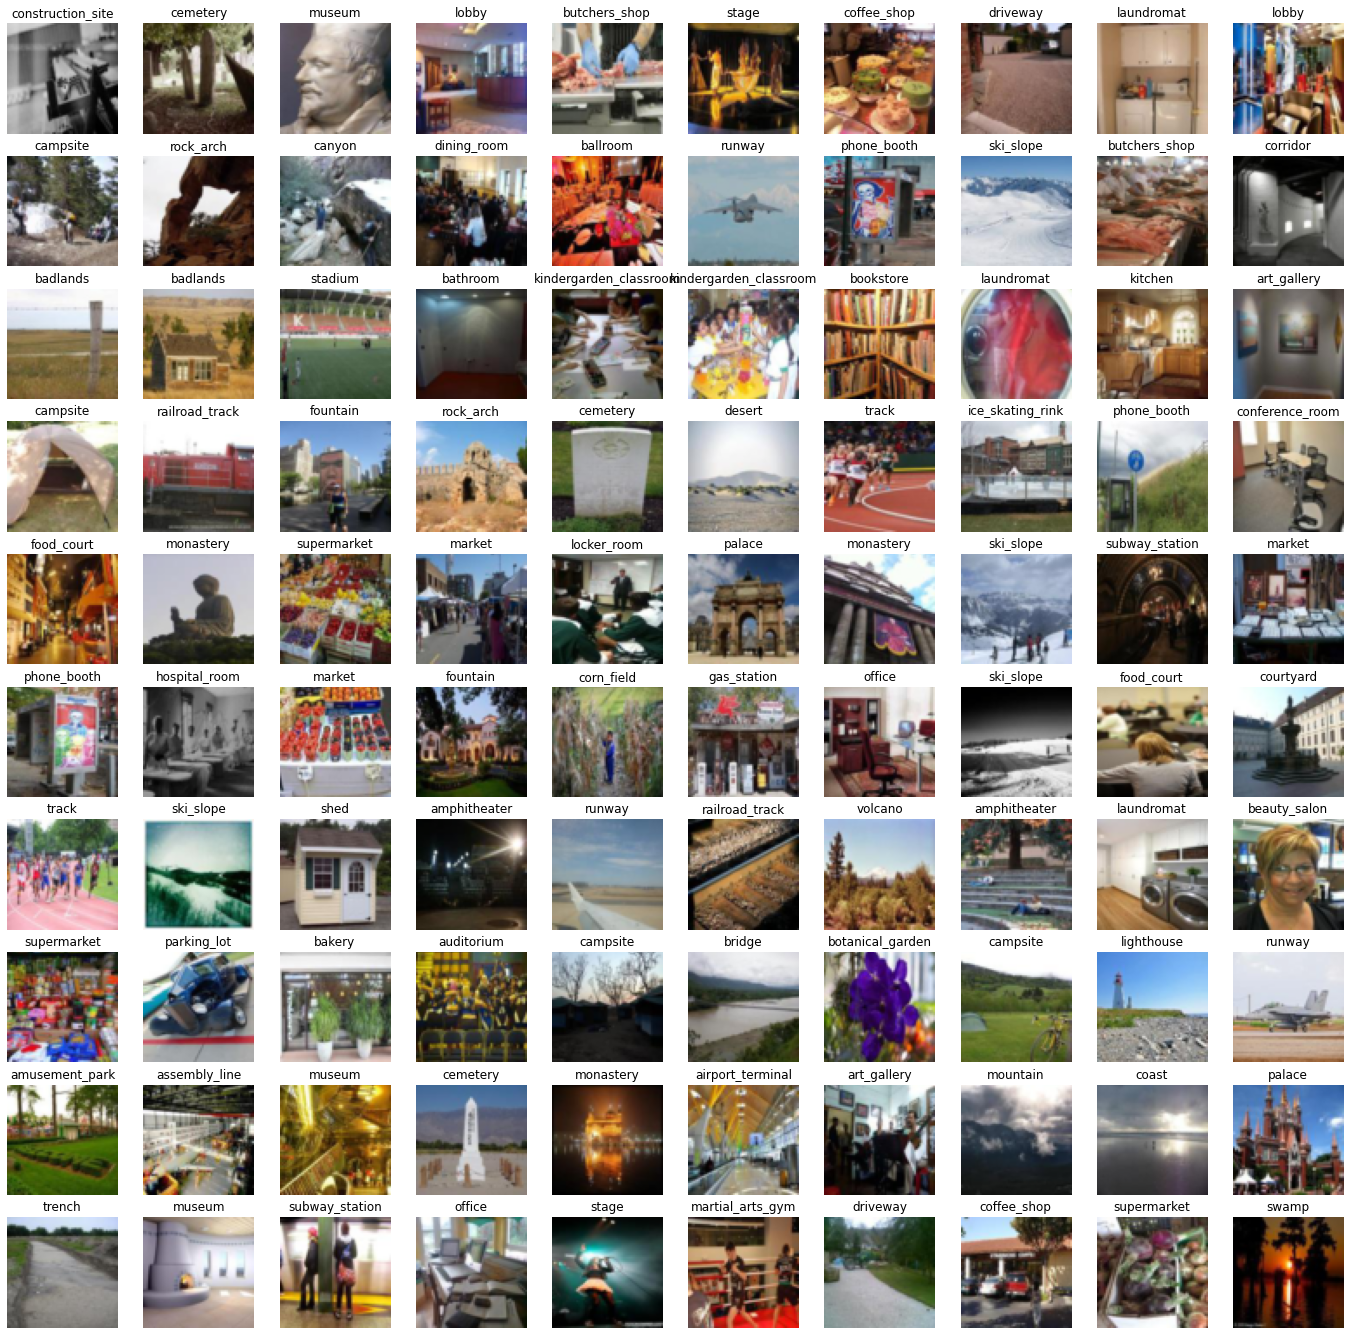

In [14]:
figure = plt.figure(figsize=(24, 24))
cols, rows = 10, 10
for i in range(1, cols * rows + 1):
    sample_idx = torch.randint(len(miniplaces_train), size=(1,)).item()
    img, label = miniplaces_train[sample_idx]
    class_name = miniplaces_train.label_dict[label]
    figure.add_subplot(rows, cols, i)
    plt.title(class_name)
    plt.axis("off")
    plt.imshow(tensor_to_image(img))
plt.show()

## Q2: MLP Classifier (30 pts)

We will implement an MLP from scratch step by step in the following sections.




### Q2.1 Using built-in modules (10 pts)
In this question, you will implement a multi-layer perceptron (MLP) classifier using PyTorch's built-in `nn.Linear` and `F.relu` functions.

Please refer to [this link](https://colab.research.google.com/github/pytorch/tutorials/blob/gh-pages/_downloads/611efa3e10bb2b546f3a33742edc4ecc/modelsyt_tutorial.ipynb)
for model writing.

First, define the MLP class and implement the `__init__` method to define the layers of the MLP:

In [31]:
import torch
import torch.nn as nn
import torch.nn.functional as F

class FastMLP(nn.Module):
    def __init__(self, input_size, hidden_size, num_classes):
        """
        Initialize an MLP classifier.
        You can use Pytorch's built-in nn.Linear function.
        Input and output sizes of each layer:
          1) fc1: input_size, hidden_size
          2) fc2: hidden_size, hidden_size
          3) fc3: hidden_size, num_classes
        
        Args:
            input_size (int): Size of the input layer.
            hidden_size (int): Size of the hidden layer.
            num_classes (int): Number of classes in the output layer.
        """
        super().__init__()
        #self.fc1 = None
        #self.fc2 = None
        #self.fc3 = None
        ################# Your Implementations #################################
        # TODO: Define the layers of the MLP
        #pass
        self.fc1 = nn.Linear(in_features=input_size, out_features= hidden_size)
        self.fc2 = nn.Linear(in_features=hidden_size, out_features=hidden_size)
        self.fc3 = nn.Linear(in_features=hidden_size, out_features=num_classes)

        ################# End of your Implementations ##########################
        
    def forward(self, x):
        """
        Forward pass of the MLP classifier.
        Using ReLU as the activation function after each layer, except for the output layer.
        Args:
            x (torch.Tensor): Input tensor of shape (batch_size, input_size).
            
        Returns:
            torch.Tensor: Output tensor of shape (batch_size, num_classes).
        """
        # Hint: call ReLu just by F.relu, where F is imported in the top line of this cell.
        ################# Your Implementations #################################
        # TODO: Implement the forward pass of the MLP classifier
        #pass
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = F.relu(self.fc3(x))
        
        ################# End of your Implementations ##########################
        return x



Then, define the training and evaluation functions to train and test the MLP classifier (You don't need to modify this part):

In [32]:

def train(model, train_loader, val_loader, optimizer, criterion, device, num_epochs):
    """
    Train the MLP classifier on the training set and evaluate it on the validation set every epoch.
    
    Args:
        model (MLP): MLP classifier to train.
        train_loader (torch.utils.data.DataLoader): Data loader for the training set.
        val_loader (torch.utils.data.DataLoader): Data loader for the validation set.
        optimizer (torch.optim.Optimizer): Optimizer to use for training.
        criterion (callable): Loss function to use for training.
        device (torch.device): Device to use for training.
        num_epochs (int): Number of epochs to train the model.
    """
    # Place model on device
    model = model.to(device)
    
    for epoch in range(num_epochs):
        model.train()  # Set model to training mode
        
        # Use tqdm to display a progress bar during training
        with tqdm(total=len(train_loader), desc=f'Epoch {epoch + 1}/{num_epochs}') as pbar:
            for inputs, labels in train_loader:
                # Move inputs and labels to device
                inputs = inputs.to(device)
                labels = labels.to(device)
                
                # Zero out gradients
                optimizer.zero_grad()
                
                # Compute the logits and loss
                logits = model(inputs)
                loss = criterion(logits, labels)
                
                # Backpropagate the loss
                loss.backward()
                
                # Update the weights
                optimizer.step()
                
                # Update the progress bar
                pbar.update(1)
                pbar.set_postfix(loss=loss.item())
        
        # Evaluate the model on the validation set
        avg_loss, accuracy = evaluate(model, val_loader, criterion, device)
        print(f'Validation set: Average loss = {avg_loss:.4f}, Accuracy = {accuracy:.4f}')

def evaluate(model, test_loader, criterion, device):
    """
    Evaluate the MLP classifier on the test set.
    
    Args:
        model (MLP): MLP classifier to evaluate.
        test_loader (torch.utils.data.DataLoader): Data loader for the test set.
        criterion (callable): Loss function to use for evaluation.
        device (torch.device): Device to use for evaluation.
        
    Returns:
        float: Average loss on the test set.
        float: Accuracy on the test set.
    """
    model.eval()  # Set model to evaluation mode
    
    with torch.no_grad():
        total_loss = 0.0
        num_correct = 0
        num_samples = 0
        
        for inputs, labels in test_loader:
            # Move inputs and labels to device
            inputs = inputs.to(device)
            labels = labels.to(device)
            
            # Compute the logits and loss
            logits = model(inputs)
            loss = criterion(logits, labels)
            total_loss += loss.item()
            
            # Compute the accuracy
            _, predictions = torch.max(logits, dim=1)
            num_correct += (predictions == labels).sum().item()
            num_samples += len(inputs)
            
    # Compute the average loss and accuracy
    avg_loss = total_loss / len(test_loader)
    accuracy = num_correct / num_samples
    
    return avg_loss, accuracy

Before we really train something, seed everything.

In [33]:
# Also, seed everything for reproducibility
# code from https://gist.github.com/ihoromi4/b681a9088f348942b01711f251e5f964#file-seed_everything-py
def seed_everything(seed: int):
    import random, os
    import numpy as np
    import torch
    random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = True

In [34]:
# Define the device to use for training
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
if device == torch.device('cuda'):
    print(f'Using device: {device}. Good to go!')
else:
    print('Please set GPU via Edit -> Notebook Settings.')

Using device: cuda. Good to go!


Since we're using MLP, the input images should be flattened.
We should append a flatten function to the `data_transform` object.

In [35]:
data_transform_flatten = transforms.Compose(
    [data_transform, torch.flatten]) # pay attention to the torch.flatten operation here
print('original transform:', data_transform)
print('new transform:', data_transform_flatten)

original transform: Compose(
    Resize(size=(64, 64), interpolation=bilinear, max_size=None, antialias=None)
    ToTensor()
    Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
)
new transform: Compose(
    Compose(
    Resize(size=(64, 64), interpolation=bilinear, max_size=None, antialias=None)
    ToTensor()
    Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
)
    <built-in method flatten of type object at 0x7f3e55bd2420>
)


#### Bookmark: Build dataset and data loader

We will also use the built-in cross-entropy loss and SGD optimizer to train the model.
Each epoch takes approximately 2 minutes.

In [36]:
seed_everything(0)

# Define the model, optimizer, and criterion (loss_fn)
model = FastMLP(
    input_size=3 * 64 * 64, 
    hidden_size=1024, 
    num_classes=len(miniplaces_train.label_dict))

optimizer = torch.optim.SGD(
    model.parameters(), 
    lr=0.01, 
    momentum=0.9)

criterion = nn.CrossEntropyLoss()


# Define the dataset and data transform with flatten functions appended
data_root = os.path.join(root_dir, 'data')
train_dataset = MiniPlaces(
    root_dir=data_root, split='train', 
    transform=data_transform_flatten)

val_dataset = MiniPlaces(
    root_dir=data_root, split='val', 
    transform=data_transform_flatten,
    label_dict=train_dataset.label_dict)

# Define the batch size and number of workers
batch_size = 64
num_workers = 2

# Define the data loaders
train_loader = torch.utils.data.DataLoader(
    train_dataset, batch_size=batch_size, num_workers=num_workers, shuffle=True)
val_loader = torch.utils.data.DataLoader(
    val_dataset, batch_size=batch_size, num_workers=num_workers, shuffle=False)

# Train the model
train(model, train_loader, val_loader, optimizer, criterion, device, num_epochs=2)

Epoch 1/2: 100%|██████████| 1563/1563 [01:33<00:00, 16.71it/s, loss=3.87]


Validation set: Average loss = 3.9685, Accuracy = 0.0991


Epoch 2/2: 100%|██████████| 1563/1563 [01:28<00:00, 17.71it/s, loss=3.93]


Validation set: Average loss = 3.9072, Accuracy = 0.1162


I can achieve a validation accuracy of 11.59% after training for two epochs. How about you?

It's normal for the accuracy to be low since our input has `len(dataset) * 3 * 64 * 64 = len(dataset) * 12288` values, while our model only has a few parameters (3-layer MLP) and we only trained this model for 2 epochs.

----
Training this small MLP on our dataset can take approximately 4 minutes (2 epochs) on a T4 cloud GPU, which can still be a tedious wait.

Remember the trick for debugging that we used in the first assignment: subsampling the dataset to obtain a small subset. But, it's important to compare different methods under the same setting: all models should be trained using the same training set and evaluated on the same validation set.

Once you are satisfied with the results, you can change back to the original dataset.

### Q2.2 Building MLP from scratch (10 pts)

In the next task, you will implement your own Multi-Layer Perceptron (MLP) without using built-in PyTorch modules.

This task should be relatively straightforward, as you have already implemented most of the required components in the previous assignment. You can simply copy and paste them here. However, be mindful of any changes in the input and output dimensions that may be required for this specific assignment.

In [37]:
class MyLinear(nn.Module):
    def __init__(self, in_features, out_features):
        """
        Initialize a linear layer.
        
        Args:
            in_features (int): Size of the input layer.
            out_features (int): Size of the output layer.
        """
        super().__init__()
        # You can use the initialization methods you created in Assignment 1
        # Here is a more common way to define learnable parameters in torch.
        self.weight = nn.Parameter(torch.randn(in_features, out_features) * 0.01)
        self.bias = nn.Parameter(torch.zeros(out_features))
        
    def forward(self, x):
        """
        Forward pass of the linear layer.
        
        Args:
            x (torch.Tensor): Input tensor of shape (batch_size, in_features).
            
        Returns:
            torch.Tensor: Output tensor of shape (batch_size, out_features).
        """
        ################# Your Implementations #####################################
        # TODO: Implement the forward pass of the linear layer
        #pass 
        out = torch.add(torch.mm(x, self.weight), self.bias)
        ################# End of your Implementations ##############################
        return out

Recall the definition of ReLu in class. Implement the ReLU activation function:

In [38]:
def relu(input):
    """
    Apply the ReLU activation function element-wise to the input tensor.
    
    Args:
        input (torch.Tensor): Input tensor with any shape.
        
    Returns:
        torch.Tensor: Output tensor with the same shape as the input tensor, 
        containing the element-wise ReLU of the input tensor.
    """
    outputs = None
    ################# Your Implementations #####################################
    #pass
    #outputs = max(0,input)
    input[input < 0] = 0
    ################# End of your Implementations ##############################
    #return outputs
    return input

Implement your own MLP using `MyLinear` and your defined `relu`.

In [46]:
class MyMLP(nn.Module):
    def __init__(self, input_size, hidden_size, num_classes):
        """
        Initialize an MLP classifier.
        You can use Pytorch's built-in nn.Linear function.
        Input and output sizes of each layer:
          1) fc1: input_size, hidden_size
          2) fc2: hidden_size, hidden_size
          3) fc3: hidden_size, num_classes
        
        Args:
            input_size (int): Size of the input layer.
            hidden_size (int): Size of the hidden layer.
            num_classes (int): Number of classes in the output layer.
        """
        super().__init__()
        self.fc1 = None
        self.fc2 = None
        self.fc3 = None
        ################# Your Implementations #################################
        # TODO: Define the layers of the MLP using `MyLinear`
        #pass
        self.fc1 = MyLinear(input_size, hidden_size)
        self.fc2 = MyLinear(hidden_size, hidden_size)
        self.fc3 = MyLinear(hidden_size, num_classes)

        ################# End of your Implementations ##########################

    def forward(self, x):
        """
        Forward pass of the MLP classifier.
        Using ReLU as the activation function after each layer, except for the output layer.
        Args:
            x (torch.Tensor): Input tensor of shape (batch_size, input_size).
            
        Returns:
            torch.Tensor: Output tensor of shape (batch_size, num_classes).
        """
        ################# Your Implementations #################################
        # TODO: Implement the forward pass of the MLP classifier
        #pass
        x = self.fc1(x)
        x = relu(x)
        x = self.fc2(x)
        x = relu(x)
        x = self.fc3(x)
        
        ################# End of your Implementations ##########################
        return x

Now, test your own implementation. You should get similar results as using built-in modules.

In [47]:
seed_everything(0)

# Define the model, optimizer, and criterion (loss_fn)
model = MyMLP(input_size=3 * 64 * 64, 
                hidden_size=1024, 
                num_classes=len(miniplaces_train.label_dict))
optimizer = torch.optim.SGD(model.parameters(), lr=0.01, momentum=0.9)
criterion = nn.CrossEntropyLoss()

# train_loader and val_loader have been declared before.
# Train the model
train(model, train_loader, val_loader, optimizer, criterion, device, num_epochs=2)

Epoch 1/2: 100%|██████████| 1563/1563 [01:56<00:00, 13.39it/s, loss=4.04]


Validation set: Average loss = 3.9069, Accuracy = 0.1064


Epoch 2/2: 100%|██████████| 1563/1563 [01:58<00:00, 13.17it/s, loss=3.26]


Validation set: Average loss = 3.8714, Accuracy = 0.1127


If your implementation is correct, you should get a similar validation accuracy (most possibly lower).

### Cross entropy loss

In [48]:
def softmax(x):
    # Implement the softmax function
    # x is the input data with shape (batch_size, input_size)
    # Return the softmax output with shape (batch_size, output_size)
    # You can copy the one you implemented in Assignment 1
    softmax_output = None
    ################# Your Implementations ################################
    #pass
    softmax_output = torch.exp(x) / torch.sum(torch.exp(x), dim=1, keepdim=True)

    ################# End of your Implementations ##########################
    return softmax_output

def nll_loss(pred_probs, targets):
    # Calculate the negative log likelihood loss
    # pred_probs is the predicted probability distribution with shape (batch_size, output_size)
    # targets is the ground-truth labels with shape (batch_size,)
    # Return the negative log likelihood loss 

    nll_loss = None
    # Hine: Convert the ground-truth labels to one-hot encoding using torch.eye()
    ################# Your Implementations ################################
    #pass
    #torch.eye(rows, columns, output, datatype, layout, device, requires_grad)
    one_hot_encoding = torch.eye(pred_probs.shape[1], device=pred_probs.device)[targets.long()]
    nll_loss = -torch.mean(torch.sum(one_hot_encoding * torch.log(pred_probs), dim=1))
    ################# End of your Implementations #################
    return nll_loss


class MyCrossEntropy(nn.Module):
    def __init__(self):
        super().__init__()

    def forward(self, logits, target):
        """
        Calculate the cross entropy loss for the given input and target.
        
        Args:
            logits (torch.Tensor): Input tensor with shape (batch_size, output_size).
            target (torch.Tensor): Target tensor with shape (batch_size,).
            
        Returns:
            torch.Tensor: Cross entropy loss.
        """
        pred_probs = softmax(logits)
        loss = nll_loss(pred_probs, target)
        return loss

Now, test our implementation. You should get similar results as using built-in modules.

In [49]:
seed_everything(0)

# Define the model, optimizer, and criterion (loss_fn)
model = MyMLP(input_size=3 * 64 * 64, 
                hidden_size=1024, 
                num_classes=len(miniplaces_train.label_dict))
optimizer = torch.optim.SGD(model.parameters(), lr=0.01, momentum=0.9)

# Define a cross entropy loss function using the MyCrossEntropy class
criterion = MyCrossEntropy()

# train_loader and val_loader have been declared before.
# Train the model
train(model, train_loader, val_loader, optimizer, criterion, device, num_epochs=2)

Epoch 1/2: 100%|██████████| 1563/1563 [01:34<00:00, 16.60it/s, loss=4.01]


Validation set: Average loss = 3.9039, Accuracy = 0.1064


Epoch 2/2: 100%|██████████| 1563/1563 [01:33<00:00, 16.66it/s, loss=3.21]


Validation set: Average loss = 3.8672, Accuracy = 0.1133


### Q2.3 SGD Optimizer (5 pts)

In the next task, you will implement the Stochastic Gradient Descent (SGD) optimizer from scratch.

Please note that for the purpose of this assignment, we will not be using techniques such as weight decay, damping or Nesterov. There are different variations of SGD implementations, and we have chosen this implementation for its simplicity. The pseudocode provided is a simplified version of the official implementation in PyTorch.

Please follow the pseudocode provided to implement the optimizer.

\begin{aligned}
            &\rule{110mm}{0.4pt}                                                                 \\
            &\textbf{input}      : \gamma \text{ (lr)}, \: \theta_0 \text{ (params)}, \: f(\theta)
                \text{ (objective)}, \: \\
            &\hspace{13mm} \:\mu \text{ (momentum)},
            \\[-1.ex]
            &\rule{110mm}{0.4pt}                                                                 \\
            &\textbf{for} \: t=1 \: \textbf{to} \: \ldots \: \textbf{do}                         \\
            &\hspace{5mm}\textbf{g}_t           \leftarrow   \nabla_{\theta} f_t (\boldsymbol{\theta}_{t-1})           \\
            &\hspace{5mm}\textbf{if} \: t > 1                                                   \\
            &\hspace{10mm} \textbf{g}_t \leftarrow \mu \textbf{g}_{t-1} + \textbf{g}_t           \\
            &\hspace{5mm}\textbf{else}                                                          \\
            &\hspace{10mm} \textbf{g}_t \leftarrow \textbf{g}_t                                           \\
            &\hspace{5mm}\boldsymbol{\theta}_t \leftarrow \boldsymbol{\theta}_{t-1} - \gamma \textbf{g}_t                   \\[-1.ex]
            &\rule{110mm}{0.4pt}                                                          \\[-1.ex]
            &\bf{return} \:  \theta_t                                                     \\[-1.ex]
            &\rule{110mm}{0.4pt}                                                          \\[-1.ex]
       \end{aligned}

In [50]:
class MySGD():
    def __init__(self, params, lr=0.01, momentum=0.9):
        """
        Initialize the MySGD optimizer.
        Args:
          params (iterable): An iterable of parameters to optimize.
          lr (float, optional): learning rate. (default: 0.01)
          momentum (float, optional): momentum factor. (default: 0.9)
        """
        self.params = list(params)
        self.lr = lr
        self.momentum = momentum
        self.grad_buffer = {}

    def zero_grad(self):
        # Set the gradients of all parameters to zero.
        for param in self.params:
            if param.grad is not None:
                param.grad.zero_()

    def step(self):
        """
        Perform one optimization step on the parameters.
        """
        for i, param in enumerate(self.params):
            if param.grad is None:
              continue
            # use i as a key to retrieve velocity from self.grad_buffer.
            # use param.data to obtain its value.
            ################# Your Implementations ################################
            #pass
            if i in self.grad_buffer:
              velocity = self.grad_buffer[i] * self.momentum + param.grad
            else:
              self.grad_buffer[i] = param.grad
              velocity = param.grad
            param.data = param.data - self.lr * velocity
            
            ################# End of your Implementations #################
            # You don't need to return anything


Now, test your own implementation. You should get similar results as using built-in modules.

In [44]:
seed_everything(0)

# Define the model, optimizer, and criterion (loss_fn)
model = MyMLP(input_size=3*64*64, 
                hidden_size=1024, 
                num_classes=len(miniplaces_train.label_dict))
optimizer = MySGD(model.parameters(), lr=0.01, momentum=0.9)

# Define a cross entropy loss function using the MyCrossEntropy class
criterion = MyCrossEntropy()

# train_loader and val_loader have been declared before.
# Train the model
train(model, train_loader, val_loader, optimizer, criterion, device, num_epochs=2)

Epoch 1/2: 100%|██████████| 1563/1563 [01:31<00:00, 17.00it/s, loss=4.35]


Validation set: Average loss = 4.1580, Accuracy = 0.0834


Epoch 2/2: 100%|██████████| 1563/1563 [01:30<00:00, 17.36it/s, loss=3.63]


Validation set: Average loss = 4.0000, Accuracy = 0.1093


### Q2.4 Adam Optimizer (5 pts)

Now, move on to the Adam optimizer.

Let's see how the Pytorch's built-in Adam works like at first.

In [51]:
seed_everything(0)

# Define the model, optimizer, and criterion (loss_fn)

# Your own implementation
model = MyMLP(input_size=3 * 64 * 64, 
                hidden_size=1024, 
                num_classes=len(miniplaces_train.label_dict))

######## Pytorch built-in Adam optimizer ################
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
#########################################################

# Define a cross entropy loss function using the MyCrossEntropy class
#criterion = None
########## Your own implementation ########
#pass
criterion = MyCrossEntropy()

###########################################

# train_loader and val_loader have been declared before.
# Train the model
train(model, train_loader, val_loader, optimizer, criterion, device, num_epochs=2)

Epoch 1/2: 100%|██████████| 1563/1563 [01:34<00:00, 16.60it/s, loss=4.12]


Validation set: Average loss = 4.1219, Accuracy = 0.0713


Epoch 2/2: 100%|██████████| 1563/1563 [01:34<00:00, 16.62it/s, loss=3.55]


Validation set: Average loss = 4.1154, Accuracy = 0.0737


I can get a validation accuracy of 6.97%. How about you?

Keep in mind that a low validation accuracy is to be expected when working with a large dataset and a small model with a limited number of parameters. Additionally, the number of training epochs also plays a role in the final validation accuracy.

----
Next, you will implement the Adam optimizer from scratch.

Note that here we don't use weight decay or amsgrad here. There are different variants of Adam implementations. We choose this implementation for simplicity. The pseudocode here is a simplified version from the official implementation in Pytorch.

Follow the pseudocode provided to implement your own optimizer.

\begin{aligned}
            &\rule{110mm}{0.4pt}                                                                 \\
            &\textbf{input}      : \gamma \text{ (lr)}, \beta_1, \beta_2
                \text{ (betas)},\theta_0 \text{ (params)},f(\theta) \text{ (objective)}          \\
            &\textbf{initialize} :  m_0 \leftarrow 0 \text{ ( first moment)},
                v_0\leftarrow 0 \text{ (second moment)}\\[-1.ex]
            &\rule{110mm}{0.4pt}                                                                 \\
            &\textbf{for} \: t=1 \: \textbf{to} \: \ldots \: \textbf{do}                         \\
            &\hspace{5mm}g_t           \leftarrow   \nabla_{\theta} f_t (\theta_{t-1})          \\
            &\hspace{5mm}m_t           \leftarrow   \beta_1 m_{t-1} + (1 - \beta_1) g_t          \\
            &\hspace{5mm}v_t           \leftarrow   \beta_2 v_{t-1} + (1-\beta_2) g^2_t          \\
            &\hspace{5mm}\widehat{m_t} \leftarrow   m_t/\big(1-\beta_1^t \big)                   \\
            &\hspace{5mm}\widehat{v_t} \leftarrow   v_t/\big(1-\beta_2^t \big)                   \\
            &\hspace{5mm}\theta_t \leftarrow \theta_{t-1} - \gamma \widehat{m_t}/
                \big(\sqrt{\hat{v_t}} + \epsilon \big)                                       \\
            &\rule{110mm}{0.4pt}                                                          \\[-1.ex]
            &\bf{return} \:  \theta_t                                                     \\[-1.ex]
            &\rule{110mm}{0.4pt}                                                          \\[-1.ex]
       \end{aligned}

In [52]:
class MyAdam():
    def __init__(self, params, lr=0.01, beta1=0.9, beta2=0.999, eps=1e-8):
        """
        Initialize the MyAdam optimizer.
        Args:
          params (iterable): An iterable of parameters to optimize.
          lr (float, optional): learning rate. (default: 0.01)
          beta1 (float, optional): first moment factor. (default: 0.9)
          beta2 (float, optional): second moment factor. (default: 0.999)
          eps (float, optional): term to avoid division by zero. (default: 1e-8)
        """
        self.params = list(params)
        self.lr = lr
        self.beta1 = beta1
        self.beta2 = beta2
        self.eps = eps
        self.first_moments = {}
        self.second_moments = {}
        # Iteration counter
        self.t = 0
        
    def zero_grad(self):
        # Set the gradients of all parameters to zero.
        for param in self.params:
            if param.grad is not None:
                param.grad.zero_()
        
    def step(self):
        self.t += 1
        for i, param in enumerate(self.params):
            if param.grad is None:
              continue
            # use i as a key to retrieve velocity from self.grad_buffer.
            # use param.data to obtain its value.
            ################# Your Implementations ################################
            #pass
            velocity = param.grad
            if i in self.first_moments:
              self.first_moments[i] = self.beta1 * self.first_moments[i] + (1 - self.beta1) * velocity
              self.second_moments[i] = self.beta2 * self.second_moments[i] + (1 - self.beta2) * velocity * velocity
            else:
              self.first_moments[i] = (1 - self.beta1) * velocity
              self.second_moments[i] = (1 - self.beta2) * velocity * velocity
            fst_moment = self.first_moments[i] / (1 - self.beta1)
            snd_moment = self.second_moments[i] / (1 - self.beta2)
            param.data = param.data - self.lr * fst_moment / (torch.sqrt(snd_moment) + self.eps)
            
            ################# End of your Implementations #################
            # You don't need to return anything


In [53]:
seed_everything(0)

# Define the model, optimizer, and criterion (loss_fn)
model = MyMLP(input_size=3*64*64, 
                hidden_size=1024, 
                num_classes=len(miniplaces_train.label_dict))

optimizer = None 
######## Your own implementation ################
#pass
optimizer = MyAdam(model.parameters(), lr=0.001)

#################################################

# Define a cross entropy loss function using the MyCrossEntropy class
criterion = None
########## Your own implementation ########
#pass
criterion = MyCrossEntropy()

###########################################

# train_loader and val_loader have been declared before.
# Train the model
train(model, train_loader, val_loader, optimizer, criterion, device, num_epochs=2)

Epoch 1/2: 100%|██████████| 1563/1563 [01:35<00:00, 16.40it/s, loss=4.08]


Validation set: Average loss = 3.9884, Accuracy = 0.0917


Epoch 2/2: 100%|██████████| 1563/1563 [01:37<00:00, 16.07it/s, loss=3.48]


Validation set: Average loss = 3.9345, Accuracy = 0.1003


I got an accuracy of 7.04% using my own implementation. How about you?

## Q3: Convolutional Neural Network (CNN), (30 pts)

In this question, you will learn how to implement convolutional neural networks (CNNs) using PyTorch. 

Similarly as Q2, we will first build a two-layer convolutional neural networks using PyTorch built-in function `nn.Conv2D` and then build the convolution operation from scratch.

### Q3.1 Fast Conv 10 pts

In [54]:
import torch
import torch.nn as nn
import torch.nn.functional as F

class FastConv(nn.Module):
    def __init__(
        self, 
        input_channels, conv_hidden_channels, conv_out_channels,
        input_size=(64,64),
        dropout_rate1=0.25, dropout_rate2=0.5,
        fc_out_channels=128, num_classes=100,
        kernel_size=3, stride=1, padding=1):
        """
        Args:
          input_channels (int): Number of channels in the input image.
          conv_hidden_channels (int): Number of channels in the first convolutional layer.
          conv_out_channels (int): Number of channels in the second convolutional layer.
          input_size (tuple, optional): Height and width of the input image. (default: (64,64))
          dropout_rate1, dropout_rate2 (float, optional): Dropout rate for 
              the first/second dropout layer. (default: 0.25, 0.5)
          fc_out_channels (int, optional): Number of neurons in the first fully 
              connected layer. (default: 128)
          num_classes (int, optional): Number of classes in the final output layer. (default: 100)
          kernel_size, stride, padding (int, optional): Parameters of convolutional layers.

        Initialize a convolutional neural network.
        You can use Pytorch's built-in nn.Conv2d function.
        Input and output shapes of each layer:
        1) conv1: (batch_size, input_channels, H, W) -> (batch_size, conv_hidden_channels, H, W)
        2) conv2: (batch_size, conv_hidden_channels, H, W) -> (batch_size, conv_out_channels, H, W)
        3) max_pooling: (batch_size, conv_out_channels, H//2, W//2)
        4) fc1: (batch_size, flatten_size) -> (batch_size, fc_out_channels)
        5) fc2: (batch_size, fc_out_channels) -> (batch_size, num_classes)
        """
        super().__init__()
        
        self.conv1 = None
        self.conv2 = None
        self.max_pooling = None
        self.dropout1 = None
        self.dropout2 = None
        self.fc1 = None
        self.fc2 = None
        ################# Your Implementations #################################
        # TODO: Define the layers of the convolutional neural network
        # replace "None"s with your implementations. 
        # All you need to do is to pass the input arguments to different constructors
        #pass
        self.conv1 = nn.Conv2d(in_channels=input_channels, out_channels=conv_hidden_channels, kernel_size=kernel_size, stride=stride, padding=padding)
        self.conv2 = nn.Conv2d(in_channels=conv_hidden_channels, out_channels=conv_out_channels, kernel_size=kernel_size, stride=stride, padding=padding)
        self.max_pooling = nn.MaxPool2d(kernel_size=2)
        self.dropout1 = nn.Dropout(p=dropout_rate1)
        self.dropout2 = nn.Dropout(p=dropout_rate2)
        self.fc1 = nn.Linear(in_features=(input_size[0] // 2 * input_size[1] // 2 * conv_out_channels), out_features=fc_out_channels)
        self.fc2 = nn.Linear(in_features=fc_out_channels, out_features=num_classes)

        ################# End of your Implementations ##########################
        
    def forward(self, x, return_intermediate=False):
        """
        Forward pass of the convolutional neural network.
        The input tensor 'x' should pass through the following layers:
        1) conv1: (batch_size, input_channels, H, W) -> (batch_size, conv_hidden_channels, H, W)
        2) Apply relu.
        3) conv2: (batch_size, conv_hidden_channels, H, W) -> (batch_size, conv_out_channels, H, W)
        4) max_pooling: Perform max pooling on the output from conv2
        5) dropout1: Perform dropout on the output from max_pooling
        6) Flatten the output from dropout1
        7) fc1: Pass through a fully connected layer
        8) dropout2: Perform dropout on the output from fc1
        9) Apply relu.
        7) fc2: Pass the output from the actiction layer to through a fully connected 
                layer to produce the final output
        """
        ################# Your Implementations #################################
        # TODO: Implement the forward pass of the convolutional neural network
        #pass
        x = F.relu(self.conv1(x))
        x = self.max_pooling(self.conv2(x))
        x = self.dropout1(x)
        x = torch.flatten(x, start_dim=1)
        x = self.fc1(x)
        x = self.dropout2(x)
        x = F.relu(x)
        x = self.fc2(x)

        ################# End of your Implementations ##########################
        return x


We're using convolutional neural network here, so the `flatten` operation that we use for the MLP is not longer needed. However, this operation has been passed when we contructed the datasets and data loaders.

Therefore, we nned to define new datasets and new dataloaders.

Follow the example in `Bookmark: Build dataset and data loader` to construct onstruct new data loaders `conv_train_loader` and `conv_val_loader` based on the new datasets `conv_train_dataset` and `conv_val_dataset`.

In [55]:
# Define the dataset and data transform **without** flatten functions
# Construct new data loaders conv_train_loader and conv_val_loader based the new datasets.

# You should construct these objects
conv_train_loader = None
conv_val_loader = None

################# Your Implementations #################################
# Define the dataset
# Define the batch size and number of workers
# Define the data loaders
#pass

# dataset
data_root = os.path.join(root_dir, 'data')
conv_train_dataset = MiniPlaces(
    root_dir = data_root, split='train',
    transform = data_transform
)

conv_val_dataset = MiniPlaces(
    root_dir = data_root, split='val',
    transform = data_transform,
    label_dict = conv_train_dataset.label_dict
)

# batch size and number of workers
batch_size = 64
num_workers = 2

# data loaders
conv_train_loader = torch.utils.data.DataLoader( conv_train_dataset, batch_size = batch_size, num_workers = num_workers, shuffle = True)
conv_val_loader = torch.utils.data.DataLoader( conv_val_dataset, batch_size = batch_size, num_workers = num_workers, shuffle = False)

################# End of your Implementations ##########################

In [56]:
seed_everything(0)

# Define the model, optimizer, and criterion (loss_fn)
model = FastConv(
    input_channels=3, conv_hidden_channels=64, conv_out_channels=128,
    input_size=(64,64),
    dropout_rate1=0.25, dropout_rate2=0.5,
    fc_out_channels=128,
    kernel_size=3, stride=1, padding=1,
    num_classes=len(miniplaces_train.label_dict))

# Let's use the built-in optimizer for a full version of SGD optimizer
optimizer = torch.optim.SGD(model.parameters(), lr=0.01, momentum=0.9)

# For loss function, your implementation and the built-in loss function should 
# be almost identical.
criterion = MyCrossEntropy()

# Train the model
train(model, conv_train_loader, conv_val_loader, optimizer, criterion, device, num_epochs=2)

Epoch 1/2: 100%|██████████| 1563/1563 [01:49<00:00, 14.23it/s, loss=3.77]


Validation set: Average loss = 3.6557, Accuracy = 0.1419


Epoch 2/2: 100%|██████████| 1563/1563 [01:45<00:00, 14.85it/s, loss=3.88]


Validation set: Average loss = 3.4805, Accuracy = 0.1690


I can get 15.25% accuracy after two epochs. How about you?

### Q3.2 Building 2D Convolutional layer from sratch (20pts)

Next, we will build convolutional neural networks from scratch.


Let's ignore channels for now and see how this works with two-dimensional data had hidden representations. In the following figure, the input is a two-dimensional tensor with hegith of 3 and width of 3. We mark the shape of the tensor as $3\times3$. The height and width of the kernel are both 2. The shape of the kernel window (or convolution window) is given by the height and width of the kernel (here it is $2\times2$). 

![correlation](https://web.cs.ucla.edu/~smo3/cs188/assignment2/correlation.png)


In the two-dimensional convolution operation, we begin wiht the convolution windo position at the upper-left corner of the input tensor and slide it across the intput tensor, both from left to right and top to bottom. When the convolution window slides to a certain position, the input subtensor contained in that window and the kernel tensor are multiplied elementwise and the resulting tensor is summed up yielding a single scalar value. This result gives the value of the output tensor at the corresponding location. Here, the output tensor has a height of 2 and width of 2 and the four elements are derived from the two-dimensional cross-correlation operation:
$$
0\times0+1\times1+3\times2+4\times3=19,\\
1\times0+2\times1+4\times2+5\times3=25,\\
3\times0+4\times1+6\times2+7\times3=37,\\
4\times0+5\times1+7\times2+8\times3=43.
$$

Note that along each axis, the output size
is slightly smaller than the input size.
Because the kernel has width and height greater than one,
we can only properly compute the cross-correlation
for locations where the kernel fits wholly within the image,
the output size is given by the input size $n_h \times n_w$
minus the size of the convolution kernel $k_h \times k_w$
via

$$(n_h-k_h+1) \times (n_w-k_w+1).$$

This is the case since we need enough space
to "shift" the convolution kernel across the image.

#### Q3.2.1 One Channel Convolution (10pts)
That's start with 2D convolution with only 1 input channel and 1 kernel.
If your implementation is right, you'll get:
```
tensor([[19., 25.],
        [37., 43.]])
```

In [57]:
def conv2d(X, K):  
    """
    Compute 2D convolution. You are supposed to use matrix multiplication 
    to achieve the 2D convolution instead of torch build in convlution method.

        Args:
          X (tensor): Input tensor in the shape of (H,W).
          K (tensor): Kernel tensor in the shape of (H,W).

        Return:
          Y (tensor): Output tensor in the shape of (H,W).

    """
    Y = None
    ################# Start of your Implementations ##########################
    # Hint: Using two for loops
    #pass
    Y = torch.zeros( (X.shape[0] - K.shape[0] + 1, X.shape[1] - K.shape[1] + 1) )
    for i in range(X.shape[0] - K.shape[0] + 1):
      for j in range(X.shape[1] - K.shape[1] + 1):
        Y[i][j] = torch.sum(torch.mul(X[i:i + K.shape[0], j:j + K.shape[1]], K))

    ################# End of your Implementations ##########################
    return Y

In [58]:
# Try to debug using this code segment:
X = torch.tensor([[0.0, 1.0, 2.0], [3.0, 4.0, 5.0], [6.0, 7.0, 8.0]])
K = torch.tensor([[0.0, 1.0], [2.0, 3.0]])
conv2d(X, K)

tensor([[19., 25.],
        [37., 43.]])

Since we typically use small kernels,
for any given convolution,
we might only lose a few pixels,
but this can add up as we apply
many successive convolutional layers.
One straightforward solution to this problem
is to add extra pixels of filler around the boundary of our input image,
thus increasing the effective size of the image.
Typically, we set the values of the extra pixels to zero.
In the following image, we pad a $3 \times 3$ input,
increasing its size to $5 \times 5$.
The corresponding output then increases to a $4 \times 4$ matrix.
The shaded portions are the first output element as well as the input and kernel tensor elements used for the output computation: $0\times0+0\times1+0\times2+0\times3=0$.

![Two-dimensional cross-correlation with padding.](https://web.cs.ucla.edu/~smo3/cs188/assignment2/conv-pad.png)

In general, if we add a total of $p_h$ rows of padding
(roughly half on top and half on bottom)
and a total of $p_w$ columns of padding
(roughly half on the left and half on the right),
the output shape will be

$$(n_h-k_h+p_h+1)\times(n_w-k_w+p_w+1).$$

This means that the height and width of the output
will increase by $p_h$ and $p_w$, respectively.

In many cases, we will want to set $p_h=k_h-1$ and $p_w=k_w-1$
to give the input and output the same height and width.
This will make it easier to predict the output shape of each layer
when constructing the network.

In the next cell, you will need to add stride to the conv2d function with padding.

If your implementation is right, the correct output will be
```
tensor([[ 3.,  8.,  4.],
        [13., 25., 10.],
        [ 4.,  5.,  0.]])
```

In [59]:
def conv2d_padding(X, K, padding=0):  
    """Compute 2D convolution with zeros padding. Here, we applying the same 
        padding on both top, bottom, left and right of the input tensor.
        If the shape of X is (3,3), the size after padding 1 is (3+1x2, 3+1x2).

        Args:
          X (tensor): Input tensor in the shape of (H,W).
          K (tensor): Kernel tensor in the shape of (H,W).
          padding (int): padding in both dimensions

        Return:
          Y (tensor): Output tensor in the shape of (H,W).

    """
    Y = None
    ################# Start of your Implementations ##########################
    # Hint： Compute the shape of padded tensor first
    #pass
    X_padded = torch.zeros( (X.shape[0] + padding * 2, X.shape[1] + padding * 2) )
    # within the padded tensor, put in the original X values
    X_padded[ padding:padding + X.shape[0], padding:padding + X.shape[1] ] = X

    Y = conv2d(X_padded, K)

    ################# End of your Implementations ##########################
    return Y

In [60]:
# Try to debug using this code segment:
X = torch.tensor([[1.0, 2.0], [4.0, 5.0]])
K = torch.tensor([[0.0, 1.0], [2.0, 3.0]])
conv2d_padding(X, K, padding=1)

tensor([[ 3.,  8.,  4.],
        [13., 25., 10.],
        [ 4.,  5.,  0.]])

When computing the cross-correlation,
we start with the convolution window
at the upper-left corner of the input tensor,
and then slide it over all locations both down and to the right.
In the previous examples, we defaulted to sliding one element at a time.
However, sometimes, either for computational efficiency
or because we wish to downsample,
we move our window more than one element at a time,
skipping the intermediate locations. This is particularly useful if the convolution 
kernel is large since it captures a large area of the underlying image.

We refer to the number of rows and columns traversed per slide as *stride*.
So far, we have used strides of 1, both for height and width.
Sometimes, we may want to use a larger stride.
The following image shows a two-dimensional cross-correlation operation
with a stride of 3 vertically and 2 horizontally.
The shaded portions are the output elements as well as the input and kernel tensor elements used for the output computation: $0\times0+0\times1+1\times2+2\times3=8$, $0\times0+6\times1+0\times2+0\times3=6$.
We can see that when the second element of the first column is generated,
the convolution window slides down three rows.
The convolution window slides two columns to the right
when the second element of the first row is generated.
When the convolution window continues to slide two columns to the right on the input,
there is no output because the input element cannot fill the window
(unless we add another column of padding).

![Cross-correlation with strides of 3 and 2 for height and width, respectively.](https://web.cs.ucla.edu/~smo3/cs188/assignment2/conv-stride.png)

In general, when the stride for the height is $s_h$
and the stride for the width is $s_w$, the output shape is

$$\lfloor(n_h-k_h+p_h+s_h)/s_h\rfloor \times \lfloor(n_w-k_w+p_w+s_w)/s_w\rfloor.$$



In the next cell, you will need to add stride to the corr2d function. 

If your implementation is right, the correct output is
```
tensor([[19., 31.], 
        [50., 62.]])
```

In [61]:
def conv2d_padding_stride(X, K, padding=0,stride = 0):  
    """Compute 2D convolution with stride. Here the stride applied both
       horizontally and vertically.

        Args:
          X (tensor): Input tensor in the shape of (H,W)
          K (tensor): Kernel tensor in the shape of (H,W)
          padding (int): padding in both dimensions
          stride (int): Stride in both dimensions

        Return:
          Y (tensor): Output tensor in the shape of (H,W)
    """
    Y = None
    ################# Start of your Implementations ##########################
    #pass
    Y = torch.zeros((
        (X.shape[0] - K.shape[0] + padding + stride) // stride,
        (X.shape[1] - K.shape[1] + padding + stride) // stride
    ))

    X_padded = torch.zeros( (X.shape[0] + padding * 2 + stride, X.shape[1] + padding * 2 + stride) )
    X_padded[ padding:padding + X.shape[0], padding:padding + X.shape[1] ] = X

    for i in range(0, X.shape[0] + padding * 2, stride):
      for j in range(0, X.shape[1] + padding * 2, stride):
        Y[i//stride][j//stride] = torch.sum(torch.mul(X_padded[i:i + K.shape[0], j:j + K.shape[1]], K))

    ################# End of your Implementations ##########################
    return Y

In [62]:
# Try to debug using this code segment:
X = torch.tensor([[0.0, 1.0, 2.0, 3.0], [3.0, 4.0, 5.0, 6.0], [6.0, 7.0, 8.0, 9.0], [8.0, 9.0, 10.0, 11.0]])
K = torch.tensor([[0.0, 1.0], [2.0, 3.0]])
conv2d_padding_stride(X, K, padding=0,stride=2)

tensor([[19., 31.],
        [50., 62.]])

#### Q3.2.3 Multiple Channels 2D Convlution 10pts
When the input data contains multiple channels,
we need to construct a convolution kernel
with the same number of input channels as the input data,
so that it can perform cross-correlation with the input data.
Assuming that the number of channels for the input data is $c_i$,
the number of input channels of the convolution kernel also needs to be $c_i$. If our convolution kernel's window shape is $k_h\times k_w$,
then when $c_i=1$, we can think of our convolution kernel
as just a two-dimensional tensor of shape $k_h\times k_w$.

However, when $c_i>1$, we need a kernel
that contains a tensor of shape $k_h\times k_w$ for *every* input channel. Concatenating these $c_i$ tensors together
yields a convolution kernel of shape $c_i\times k_h\times k_w$.
Since the input and convolution kernel each have $c_i$ channels,
we can perform a cross-correlation operation
on the two-dimensional tensor of the input
and the two-dimensional tensor of the convolution kernel
for each channel, adding the $c_i$ results together
(summing over the channels)
to yield a two-dimensional tensor.
This is the result of a two-dimensional cross-correlation
between a multi-channel input and
a multi-input-channel convolution kernel.

The following image provides an example 
of a two-dimensional cross-correlation with two input channels.
The shaded portions are the first output element
as well as the input and kernel tensor elements used for the output computation:
$(1\times1+2\times2+4\times3+5\times4)+(0\times0+1\times1+3\times2+4\times3)=56$.

![Cross-correlation computation with 2 input channels.](https://web.cs.ucla.edu/~smo3/cs188/assignment2/conv-multi-in.png)


To make sure we really understand what is going on here,
we can (**implement cross-correlation operations with multiple input channels**) ourselves.
Notice that all we are doing is performing a cross-correlation operation
per channel and then adding up the results.

Then, we'll consider the cases where there are multiple input channels. If your implementation is right, the correct output is 


```
tensor([[  4.,  26.,  18.],
        [ 57., 120.,  55.],
        [ 29.,  46.,  13.]])
```



In [63]:
def conv2d_multi_in(X, K,padding=0, stride=0) -> torch.tensor:

    """Compute 2D cross-correlation with multiple input channels. 
        Here, X and K should have the same chanel number

        Args:
          X (tensor): Input tensor in the shape of (in_Channels,H,W).
          K (tensor): Kernel tensor (in_Channels,H,W)
          padding (int): padding in H,W dimensions
          stride (int): Stride in H,W dimensions

        Return:
          Y (tensor): Output tensor in the shape of (H,W)

    """
    # Hint： Iterate through the 0th dimension (channel) of K first, then stack them up, then take the sum
    Y = None
    ######################################Your Code######################################
    #pass
    Y = torch.zeros( 
        (X.shape[1] - K.shape[1] + padding * 2) // stride + 1,
        (X.shape[2] - K.shape[2] + padding * 2) // stride + 1
        )
    
    for channel_i, channel in enumerate(X):
      channel_padded = torch.zeros ((channel.shape[0] + padding * 2 + stride, channel.shape[1] + padding * 2 + stride))
      channel_padded[ padding:padding + channel.shape[0], padding:padding + channel.shape[1] ] = channel
      for i in range(0, Y.shape[0]):
        for j in range(0, Y.shape[1]):
          Y[i][j] += torch.sum(torch.mul(channel_padded[i * stride:i * stride + K.shape[1], j * stride:j * stride + K.shape[2]], K[channel_i]))
    
    #####################################################################################
    return Y

In [64]:
# Try to debug using this code segment:
X = torch.tensor([[[0.0, 1.0, 2.0,3.0], [3.0, 4.0, 5.0,6.0], [6.0, 7.0, 8.0,9.0],[9.0,10.0,11.0,12.0]],
               [[1.0, 2.0, 3.0,4.0], [4.0, 5.0, 6.0,7.0], [7.0, 8.0, 9.0,10.0],[10.0,11.0,12.0,13.0]]])
K = torch.tensor([[[0.0, 1.0], [2.0, 3.0]], [[1.0, 2.0], [3.0, 4.0]]])

out = conv2d_multi_in(X, K,padding=1, stride=2)
out

tensor([[  4.,  26.,  18.],
        [ 57., 120.,  55.],
        [ 29.,  46.,  13.]])

In [65]:
# Compare our method with torch build-in method
X = (torch.rand(2,10,10)).to(torch.float32)
K = (torch.rand(2,3,3)).to(torch.float32)
for i in [1,2,3,4,5]:
  for j in [1,2,3,4,5]:
    out = conv2d_multi_in(X, K,padding=i, stride=j)
    answer = F.conv2d(X.unsqueeze(0),K.unsqueeze(0),stride=j,padding=i).squeeze(0).squeeze(0)
    equal = torch.allclose(out,answer)

    if equal:
      print('Good! For padding: %d and stride: %d, the output match' %(i,j))
    else:
      print('Uh-oh! The output are different')
      break

Good! For padding: 1 and stride: 1, the output match
Good! For padding: 1 and stride: 2, the output match
Good! For padding: 1 and stride: 3, the output match
Good! For padding: 1 and stride: 4, the output match
Good! For padding: 1 and stride: 5, the output match
Good! For padding: 2 and stride: 1, the output match
Good! For padding: 2 and stride: 2, the output match
Good! For padding: 2 and stride: 3, the output match
Good! For padding: 2 and stride: 4, the output match
Good! For padding: 2 and stride: 5, the output match
Good! For padding: 3 and stride: 1, the output match
Good! For padding: 3 and stride: 2, the output match
Good! For padding: 3 and stride: 3, the output match
Good! For padding: 3 and stride: 4, the output match
Good! For padding: 3 and stride: 5, the output match
Good! For padding: 4 and stride: 1, the output match
Good! For padding: 4 and stride: 2, the output match
Good! For padding: 4 and stride: 3, the output match
Good! For padding: 4 and stride: 4, the output

Then, we'll consider the cases where there are multiple input channels and multiple output channels. Notice the input tensor X has a batch demension.

In [66]:
def batched_conv2d_multi_in_out(X, K,padding=0, stride=0) -> torch.tensor:

    """Compute 2D cross-correlation with multiple input channels and multiple 
        output channels. 

        Args:
          X (tensor): Input tensor in the shape of (batch_size,in_channels,H,W).
          K (tensor): Kernel tensor (out_channels,in_channels,H,W)
          padding (int): padding in H,W dimensions
          stride (int): Stride in H,W dimensions

        Return:
          Y (tensor): Output tensor in the shape of (batch_size,out_channels,H,W)

    """
    # Hint: Loop though the batch dimension and then loop though the out_channel
    #       dimension 
    Y = None
    ######################################Your Code######################################
    #pass
    Y = torch.zeros ((
        X.shape[0], K.shape[0],
        (X.shape[2] - K.shape[2] + padding * 2) // stride + 1,
        (X.shape[3] - K.shape[3] + padding * 2) // stride + 1
    ))

    for item_idx, item in enumerate(X):
      for out_channel_num, out_channel in enumerate(K):
        for channel_i, channel in enumerate(item):
          channel_padded = torch.zeros( (channel.shape[0] + padding * 2 + stride, channel.shape[1] + padding * 2 + stride) )
          channel_padded[padding:padding + channel.shape[0], padding:padding + channel.shape[1]] = channel
          for i in range(0, Y.shape[2]):
            for j in range(0, Y.shape[3]):
              Y[item_idx][out_channel_num][i][j] += torch.sum(torch.mul(channel_padded[i * stride:i * stride + out_channel.shape[1], j * stride:j * stride + out_channel.shape[2]], out_channel[channel_i]))
              

    #####################################################################################
    return Y

In [67]:
# Compare our method with torch build-in method
X = (torch.rand(2,2,10,10)).to(torch.float32)
K = (torch.rand(2,2,3,3)).to(torch.float32)
for i in [1,2,3,4,5]:
  for j in [1,2,3,4,5]:
    out = batched_conv2d_multi_in_out(X, K,padding=i, stride=j)
    answer = F.conv2d(X,K,stride=j,padding=i)
    equal = torch.allclose(out,answer)

    if equal:
      print('Good! For padding: %d and stride: %d, the output match' %(i,j))
    else:
      print('Uh-oh! The output are different')
      break

Good! For padding: 1 and stride: 1, the output match
Good! For padding: 1 and stride: 2, the output match
Good! For padding: 1 and stride: 3, the output match
Good! For padding: 1 and stride: 4, the output match
Good! For padding: 1 and stride: 5, the output match
Good! For padding: 2 and stride: 1, the output match
Good! For padding: 2 and stride: 2, the output match
Good! For padding: 2 and stride: 3, the output match
Good! For padding: 2 and stride: 4, the output match
Good! For padding: 2 and stride: 5, the output match
Good! For padding: 3 and stride: 1, the output match
Good! For padding: 3 and stride: 2, the output match
Good! For padding: 3 and stride: 3, the output match
Good! For padding: 3 and stride: 4, the output match
Good! For padding: 3 and stride: 5, the output match
Good! For padding: 4 and stride: 1, the output match
Good! For padding: 4 and stride: 2, the output match
Good! For padding: 4 and stride: 3, the output match
Good! For padding: 4 and stride: 4, the output

## Q4: Your own model (20 pts)

You will construct your own model using built-in convolutional layers. You can base your model on the provided `FastConv` class, or choose to modify the number of convolutional layers, feature size, learning rate, optimizer, and other parameters to suit your needs. You should write this model in the following code cells.

You will select the best model using the validation set, and then evaluate it on the test set. You should create a file named "test_UID.json", containing "{id: predicted_label}" pairs.

We will hold a leaderboard on the accuracy on the test set after the deadline. The top 20% of students can receive a bonus.

Feel free to organize your code in different ways. Below is an example of one possible organization for your code.

In [95]:
# Define your model.

import torch
import torch.nn as nn
import torch.nn.functional as F

class NewConv(nn.Module):
  def __init__(self, in_channels, out_channels, num_layers):
    super().__init__()

    self.conv1 = nn.Conv2d( in_channels=in_channels, out_channels=out_channels, kernel_size=3, padding=1 )
    self.conv_N = nn.ModuleList([nn.Conv2d(in_channels=out_channels, out_channels=out_channels, kernel_size=3, padding=1) for _ in range(num_layers - 1)])


  def forward(self, x, return_intermediate=False):
    x = self.conv1(x)
    for conv in self.conv_N:
      x = F.relu(conv(x))
    return x

class MyConv(nn.Module):
  def __init__(
        self, 
        input_channels, conv_layer1_channels, conv_layer2_channels, conv_out_channels,
        input_size=(64,64),
        dropout_rate1=0.25, dropout_rate2=0.5,
        fc_out_channels=128, num_classes=100,
        kernel_size=3, stride=1, padding=1):
        """
        Args:
          input_channels (int): Number of channels in the input image.
          conv_hidden_channels (int): Number of channels in the first convolutional layer.
          conv_out_channels (int): Number of channels in the second convolutional layer.
          input_size (tuple, optional): Height and width of the input image. (default: (64,64))
          dropout_rate1, dropout_rate2 (float, optional): Dropout rate for 
              the first/second dropout layer. (default: 0.25, 0.5)
          fc_out_channels (int, optional): Number of neurons in the first fully 
              connected layer. (default: 128)
          num_classes (int, optional): Number of classes in the final output layer. (default: 100)
          kernel_size, stride, padding (int, optional): Parameters of convolutional layers.

        Initialize a convolutional neural network.
        You can use Pytorch's built-in nn.Conv2d function.
        Input and output shapes of each layer:
        1) conv1: (batch_size, input_channels, H, W) -> (batch_size, conv_hidden_channels, H, W)
        2) conv2: (batch_size, conv_hidden_channels, H, W) -> (batch_size, conv_out_channels, H, W)
        3) max_pooling: (batch_size, conv_out_channels, H//2, W//2)
        4) fc1: (batch_size, flatten_size) -> (batch_size, fc_out_channels)
        5) fc2: (batch_size, fc_out_channels) -> (batch_size, num_classes)
        """
        super().__init__()
        self.layer1 = NewConv(in_channels=input_channels, out_channels=conv_layer1_channels, num_layers=2)
        self.layer2 = NewConv(in_channels=conv_layer1_channels, out_channels=conv_layer2_channels, num_layers=3)
        self.layer3 = NewConv(in_channels=conv_layer2_channels, out_channels=conv_out_channels, num_layers=4)


        self.max_pooling = nn.MaxPool2d(kernel_size=2)
        self.fc1 = nn.Linear(in_features=(input_size[0] // 2 * input_size[1] // 2 * conv_out_channels ), out_features=fc_out_channels)
        self.fc2 = nn.Linear(in_features=fc_out_channels, out_features=num_classes)
      

  def forward(self, x, return_intermediate=False):
        x = self.layer1(x)
        x = self.max_pooling(x)
        x = self.layer2(x)
        x = self.layer3(x)
        x = torch.flatten(x, start_dim=1)
        x = self.fc1(x)
        x = F.relu(x)
        x = self.fc2(x)
        return x

In [96]:
# Build train/val/test datasets and data loaders using the modules we built before.
conv_train_loader = None
conv_val_loader = None


data_root = os.path.join(root_dir, 'data')
conv_train_dataset = MiniPlaces(
    root_dir=data_root, split='train',
    transform=data_transform)

conv_val_dataset = MiniPlaces(
    root_dir=data_root, split='val', 
    transform=data_transform,
    label_dict=conv_train_dataset.label_dict)

batch_size = 64
num_workers = 2

conv_train_loader = torch.utils.data.DataLoader(
    conv_train_dataset, batch_size=batch_size, num_workers=num_workers, shuffle=True)
conv_val_loader = torch.utils.data.DataLoader(
    conv_val_dataset, batch_size=batch_size, num_workers=num_workers, shuffle=False)


In [78]:
# Train on the training set, validate on the validation set.
# Search hyper-parameters to find the best model on the validation set.
seed_everything(0)

model = MyConv(
    input_channels=3, conv_layer1_channels=64, conv_layer2_channels=128, conv_out_channels=256,
    input_size= (64, 64),
    dropout_rate1=0.25, dropout_rate2=0.5,
    fc_out_channels=128,
    num_classes = len(miniplaces_train.label_dict)
)

optimizer = torch.optim.SGD(model.parameters(), lr=0.01, momentum=0.9)
criterion = nn.CrossEntropyLoss()

train(model, conv_train_loader, conv_val_loader, optimizer, criterion, device, num_epochs=4)

Epoch 1/4: 100%|██████████| 1563/1563 [03:34<00:00,  7.28it/s, loss=4.6]


Validation set: Average loss = 4.6053, Accuracy = 0.0100


Epoch 2/4: 100%|██████████| 1563/1563 [03:39<00:00,  7.11it/s, loss=3.67]


Validation set: Average loss = 4.0242, Accuracy = 0.0672


Epoch 3/4: 100%|██████████| 1563/1563 [03:42<00:00,  7.02it/s, loss=3.91]


Validation set: Average loss = 3.5209, Accuracy = 0.1492


Epoch 4/4: 100%|██████████| 1563/1563 [03:41<00:00,  7.05it/s, loss=3.44]


Validation set: Average loss = 3.3219, Accuracy = 0.1843


In [97]:
# Generate test-set results..
# For instance: the id of image 'test/00000001.jpg' should be '00000001' in string

dir = './Assignment2/data/images/test'


conv_test_dataset = MiniPlaces(
    root_dir=data_root, split='test', 
    transform=data_transform,
    label_dict=conv_train_dataset.label_dict)
conv_test_loader = torch.utils.data.DataLoader(
    conv_test_dataset, batch_size=batch_size, num_workers=num_workers, shuffle=False)

In [98]:
preds = {}
model.eval()

with torch.no_grad():
  for inputs, ids in conv_test_loader:
    inputs = inputs.to(device)

    logits = model(inputs)
            
    _, predictions = torch.max(logits, dim=1)
    for id, pred in zip(ids, predictions):
      preds[id] = pred.item()

In [99]:
import json
json_obj = json.dumps(preds, indent=4)
with open("test_305608770.json", "w") as outfile:
  outfile.write(json_obj)